In [6]:
!pip install geonamescache


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 38.1 MB/s eta 0:00:00


Se instala la libreria geonamescache, para obtener los codigos de llamada de los paises y poder identificar paises y ciudades

In [7]:
import requests
import geonamescache
import pandas as pd
import re
import matplotlib.pyplot as plt

Se usa la libreria request para poder hacer las peticiones post y poder obtener y cargar los contacots a HubSpot

Se usa la libreria pandas para la manipulación y el análisis de datos

Se usa la libreria re para poder manipular cadenas de caracteres

Se usa la libreria matplotlib para poder graficar datos

In [8]:
def contact_collection(access_token):

    """
        Description: Contact collection, collects all records marked "true" in the "allowed_to_collect" attribute of the source account.
        Arguments: access_token - string
        Returns: contacts - dictionary list

    """

     # URL de la API para buscar contactos
    url = "https://api.hubapi.com/crm/v3/objects/contacts/search"
    # Parámetros de la solicitud, key de la API de HubSpot
    headers = {
        "Authorization": f"Bearer {access_token}"
    }
    # Cuerpo de la solicitud (filtrar por allowed_to_collect: true)
    payload = {
        "filterGroups": [
            {
                "filters": [
                    {
                        "propertyName": "allowed_to_collect",
                        "operator": "EQ",
                        "value": "true"
                    }
                ]
            }
        ],
        "properties": [
            "raw_email",
            "country",
            "phone",
            "technical_test___create_date",
            "industry",
            "address",
            "hs_object_id"
        ]
    }
    # Realizar la solicitud POST a la API de HubSpot
    response = requests.post(url, headers=headers, json=payload)
    # Verificar el estado de la respuesta
    if response.status_code == 200:
        # Obtener los datos de la respuesta en formato JSON
        data = response.json()
        # Obtener los contactos de la respuesta
        contacts = data.get("results", [])
        return contacts
    else:
        # En caso de que la solicitud no sea exitosa, mostrar el código de estado y mensaje de error
        print("Error:", response.status_code, response.text)
        return []

# 1. Create a library for ETL
## Extraction Functions:
### a) contact_collection:
Funcion usada para extraer los datos desde una api privada de HubSpot, la funcion recive como paarametro un  que es la clave para poder hacer el request y retorna una lista de diccionario con la informacion de todos los contactos que tenga en el atributo (propiedad) allowed_to_collect con un valor de "true"

In [9]:
#%%  Transformation functions:

def country_recognition(country):

    """
        Description: Country Recognition, for each country record recognizes if this record value corresponds to a country or a city and return a country or/and city name
        Arguments: country - string
        Returns: countri_name,city_name - string,string

    """
    gc = geonamescache.GeonamesCache()

    # Obtener los nombres de países y ciudades de la base de datos
    countries = gc.get_countries_by_names()
    cities = gc.get_cities()

    # Creo listas que solo contengan nombres de las ciudades, codigo del paises, y nombre de los paises cada una
    cities_names = [cities[key]['name'] for key in cities]
    countrycode = [cities[key]['countrycode'] for key in cities]
    countries_names = [countries[key]['name'] for key in countries]
    countries_code = [countries[key]['iso'] for key in countries]

    # Buscar si el string country de entrada corresponde a una ciudad
    for city_name in cities_names:
        if country.lower() == city_name.lower():
            index = cities_names.index(country)
            code = countrycode[index]
            for countri_code in countries_code:
                if code.lower() == countri_code.lower():
                    index = countries_code.index(code)
                    countri_name = countries_names[index]
                    break
            #print(city_name,code,countri_name)
            return (countri_name,city_name)

    # Si no es una ciudad, buscar si es un país
    for countri_name in countries_names:
        if country.lower() == countri_name.lower():
            #print(countri_name, '')
            return (countri_name, '')

    # Si no coincide con ningún país ni ciudad, retornar "Unknown"
    return "Unknown"


## Transformation functions:
### a) country_recognition:
Funcion usada para identificar si el atributo (propiedad) "country" que se pasa como parametro en la funcion es un Pais o una Ciudad, en el caso de ser una ciudad la funcion retorna "countri_name" una tupla de string con el nombre del pais y la ciudad, en caso de ser un pais, retorna solo el nombre del pais, se usa la libreria geonamescache para obtener una base de datos de los paises y sus ciudades.

In [11]:
def found_emails(raw_email):

    """
        Description: Found Emails, for each record, in the property “raw_email” searches and return for any sequence of characters that is enclosed between the characters < and >
        Arguments: raw_email - string
        Returns: new_email - string

    """

    # Captura el texto que se encuentra dentro de los caracteres <>
    new_email = re.search(r'<([^>]+)>', raw_email)
    # Si encuentra algun texto entre los caracteres < y >, retornar esa cadena de texto
    if new_email:
        #print(new_email.group(1))
        return(new_email.group(1))

    # Si no encuentra ningun texto entre los caracteres < y >, retornar "Unknown"
    else:
        return "Unknown"

### b) found_emails:
Funcion usada para extraer el correo electronico de una cadena de caracteres donde viene el nombre del cliente, el correo dentro de los caracteres <> y la palabra 'Contact Info', se usa la funcion re.search() para buscar dentro de atributo (propiedad) "raw_email", que se pasa como parametro, la cadena de caracteres dentro de los caracteres <> que corresponde al correo del cliente y se retorna el string "new_email" que contiene solo el correo

In [12]:
def  fix_phone_numbers(country,phone):

    """
        Description: Fix Phone Numbers, for each record, add the call code of the corresponding country and apply the format
        Arguments: country,phone - tuple containing (country_found, city_found) string, string
        Returns: new_phone - string

    """

    gc = geonamescache.GeonamesCache()
    # Obtengo solo el pais de la tupla de entrada country que contiene el nombre de pais y ciudad
    country = country[0]
    # Obtener la info de los países de la base de datos
    countries = gc.get_countries_by_names()
    # Creo dos listas que contenga los nombres de los paises y el codigo de llamada de los paises
    countries_names = [countries[key]['name'] for key in countries]
    countries_code = [countries[key]['phone'] for key in countries]
    aux = 0
    # Recorro la lista de paises countries_names uno por uno
    for countri_name in countries_names:
        # Buscar si el string country de entrada corresponde a un pais
        if country.lower() == countri_name.lower():
            # Si encuentro el pais, guardo el indice donde se encuentra dentro de la lista countries_names
            index = countries_names.index(country)
            # Con el indice creo el call_code con la lista countries_code
            call_code = f"(+{countries_code[index]})"
            # Eliminar el '0' si es el primer dígito y eliminar los guiones '-' del numero phone que se recibe como parametro
            clean_number = phone.replace('-', '').lstrip('0')
            # Creo el formato con espacios XXXX XXXXXX
            format_numeber = '{} {}'.format(clean_number[:4], clean_number[4:])
            # Uno el call_code con format_numeber para obtener el nuevo numero con el formato final (+XXX) XXXX XXXXXX
            new_phone = f"{call_code} {format_numeber}"
            #print (new_phone)
            aux = 1
            return (new_phone)
    # Si no encuentra ningun pais que coincida para obtener el codigo de llamada pongo por defecto (+000) con el numero de entrada phone con el nuevo formato"
    if aux == 0:
        call_code = "(+000)"
        # Eliminar el '0' si es el primer dígito y eliminar los guiones '-' del numero phone que se recibe como parametro
        clean_number = phone.replace('-', '').lstrip('0')
        # Creo el formato con espacios XXXX XXXXXX
        format_numeber = '{} {}'.format(clean_number[:4], clean_number[4:])
        # Uno el call_code con format_numeber para obtener el nuevo numero con el formato final (+XXX) XXXX XXXXXX
        new_phone = f"{call_code} {format_numeber}"
        #print (new_phone)
        return (new_phone)


### c) fix_phone_numbers:

Funcion usada para agregar codigo de llamada de cada pais y un formato especifico al atributo (propiedad) "phone", que se pasa como parametro, primero se busca el codigo de llamada del pais por medio de la libreria geonamescache pasando como parametro la tupla de Pais y Ciudad obtenidas con la funcion country_recognition y luego se le aplica el formato especificado, la funcion retorna el string "new_phone"


In [14]:
def found_name(raw_email):

    """
        Description: Found Names, for each record, in the property “raw_email” searches and return the first part of the character string up to before the '<' character containing the first name
        Arguments: raw_email - string
        Returns: name - string

    """

    # Obtener la primera parte de raw_email que contiene solo el nombre sin espacios
    name = raw_email.split('<')[0].strip()
    # Si encuentra algun nombre antes del caracter <, retornar esa cadena de texto
    if name:
        return(name)

    # Si no encuentra ningun nombre antes del caracter <, retornar "Unknown"
    else:
        return "Unknown"

### d) found_name:

Funcion adicional usada para obtener el primer nombre del cliente que se encuentra al principio de la cadena de caracteres del atributo (propiedad) "raw_email", que se pasa como parametro en la funcion, se usa la funcion .split() y .strip() para obtener la primera parte del string y se retorna un nuevo string "name"

In [15]:
# %% Load Functions:

def saving_contacts(contacts,access_token):

    """
        Description: Saving Contacts, Take contact records after data transformation and upload to HUBSPOT private API
        Arguments: contacts,access_toke - dictionary list,string
        Returns: any

    """

    # URL de la API para buscar contactos
    url = "https://api.hubapi.com/crm/v3/objects/contacts"
    # Parámetros de la solicitud, key de la API de HubSpot
    headers = {
        "Authorization": f"Bearer {access_token}",
        "Content-Type": "application/json"
    }
    for contact in contacts:
        # Cuerpo de la solicitud
        payload = {

            "id" : contact["hs_object_id"],

            "properties": {
                    "email": contact["email"],
                    "firstname" : contact["nombre"],
                    "phone": contact["telefono"],
                    "country": contact["pais"],
                    "city": contact["ciudad"],
                    "original_create_date": contact["technical_test___create_date"],
                    "original_industry": contact["industry"],
                    "temporary_id": contact["hs_object_id"]


            }
        }
        # Realizar la solicitud POST a la API de HubSpot
        response = requests.post(url, headers=headers, json=payload)
        # Verificar el estado de la respuesta
        if response.status_code == 200 or response.status_code == 201:
            print('Contacto guardado en HubSpot:', contact['email'])
        else:
            print('Error al guardar el contacto:', response.status_code, contact['email'], response.text)


## Load Functions:
### a) saving_contacts:

Funcion usada para cargar los datos de los contactos en mi api privad de HubSpot, luego de realizar la extraccion y la transformacion de los mismos, se recive una lista de diccionarios "contacts" con los datos de todos los contactos y un string "access_token" con el key de acceso

In [20]:
# %% Duplicates Management

def duplicate_management(contacts):

    """
        Description: Duplicates Management, algorithm to eliminate contacts that have duplicate emails, or if they do not have email, duplicate names, too
        if an old record contains data that the new one does not, please add it to the most recent record
        Arguments: contacts - list of dictionary
        Returns: merged_datas - list of dictionary

    """
    # Ordenar la lista de diccionarios por fecha de technical_test___create_date de forma descendente
    contacts_sorted = sorted(contacts, key=lambda x: x['technical_test___create_date'], reverse=True)
    # Convierto la lista de diccionarios en un DataFrame para manejar con mayor facilidad
    df = pd.DataFrame(contacts_sorted)
    # Lista auxiliar donde guardare los valores de cada posicion para luego compararlos con el resto de contactos
    merged_datas = []
    aux = 0
    # Ciclo for para recorer cada uno de los contactos
    for row in range(df.shape[0]):
        # Guardo variables que usare para comparar
        email = df.iloc[row]['email']
        nombre = df.iloc[row]['nombre']
        industria = df.iloc[row]['industry']
        # Guardo en el directorio merged_data los valores de cada contacto que recorro en el ciclo for
        merged_data = {
            'email': df.iloc[row]['email'],
            'nombre' : df.iloc[row]['nombre'],
            'telefono': df.iloc[row]['telefono'],
            'pais': df.iloc[row]['pais'],
            'ciudad' : df.iloc[row]['ciudad'],
            'technical_test___create_date' : df.iloc[row]['technical_test___create_date'],
            'industry' : df.iloc[row]['industry'],
            'hs_object_id' : df.iloc[row]["hs_object_id"]
        }
        #print (email,nombre,industria,df.shape[0],aux,row)
        aux = aux+1
        # Si es el ultimo registro, no tengo mas registros para comparar, por lo cual es unico, lo guardo y rompo el ciclo
        if (df.shape[0]-1) == row :
            merged_datas.append(merged_data)
            break
        # Ciclo for para recorrer los registros de contactos con los que voy a compara los valores del diccionario merged_data
        for i in range(aux,df.shape[0]):
            #print ("llega aqui")
            #print (i)
            # comparo si el email guardado en merged_data es igual a los emails de los otros contactos
            if  i <= (df.shape[0]-1) and email == df.iloc[i]['email']:
                #print("entra aqui1")
                # Si algun dato del diccionario merged_data esta vacio remplacelo por el dato del contacto mas reciente con el mismo correo
                if merged_data['nombre'] == '' :
                    merged_data['nombre'] = df.iloc[i]['nombre']
                if merged_data['telefono'] == '' :
                    merged_data['telefono'] = df.iloc[i]['telefono']
                if merged_data['pais'] == '' :
                    merged_data['pais'] = df.iloc[i]['pais']
                if merged_data['ciudad'] == '' :
                    merged_data['ciudad'] = df.iloc[i]['ciudad']
                if merged_data['technical_test___create_date'] == '' :
                    merged_data['technical_test___create_date'] = df.iloc[i]['technical_test___create_date']
                if merged_data['industry'] != df.iloc[i]['industry'] :
                    merged_data['industry'] = merged_data['industry'] + ';' + df.iloc[i]['industry']
                #print (merged_data)
                # Eliminar el registro con correo repetido en el dataframe
                df = df.drop(i)
        # Guardar los contactos que no estan repetidos en el diccionario final
        merged_datas.append(merged_data)
    # Reinicio valores auxiliales para repetir el mismo proceso para los casos donde un contacto tiene correo el correo vacio pero el el mismo nombre que otro contacto
    merged_datas = []
    aux = 0
    # Repito el mismo proceso pero ahora verificando que haya un correo vacio y nombres iguales
    for row in range(df.shape[0]):
        email = df.iloc[row]['email']
        nombre = df.iloc[row]['nombre']
        industria = df.iloc[row]['industry']
        merged_data = {
            'email': df.iloc[row]['email'],
            'nombre' : df.iloc[row]['nombre'],
            'telefono': df.iloc[row]['telefono'],
            'pais': df.iloc[row]['pais'],
            'ciudad' : df.iloc[row]['ciudad'],
            'technical_test___create_date' : df.iloc[row]['technical_test___create_date'],
            'industry' : df.iloc[row]['industry'],
            'hs_object_id' : df.iloc[row]["hs_object_id"]
        }
        #print (email,nombre,industria,df.shape[0],aux,row)
        aux = aux+1
        if (df.shape[0]-1) == row :
            merged_datas.append(merged_data)
            break
        for i in range(aux,df.shape[0]):
            #print ("llega aqui")
            #print (i)
            if  i <= (df.shape[0]-1) and email == "" and nombre == df.iloc[i]['nombre']:
                #print("entra aqui1")
                if merged_data['email'] == '' :
                    merged_data['email'] = df.iloc[i]['email']
                if merged_data['telefono'] == '' :
                    merged_data['telefono'] = df.iloc[i]['telefono']
                if merged_data['pais'] == '' :
                    merged_data['pais'] = df.iloc[i]['pais']
                if merged_data['ciudad'] == '' :
                    merged_data['ciudad'] = df.iloc[i]['ciudad']
                if merged_data['technical_test___create_date'] == '' :
                    merged_data['technical_test___create_date'] = df.iloc[i]['technical_test___create_date']
                if merged_data['industry'] != df.iloc[i]['industry'] :
                    merged_data['industry'] = merged_data['industry'] + ';' + df.iloc[i]['industry']
                #print (merged_data)
                df = df.drop(i)
        merged_datas.append(merged_data)
    #print (merged_datas)
    #print (df)
    return (merged_datas)

# 3. Duplicates Management:

### duplicate_management:

Funcion usada para eliminar registro repetidos ya sea por tener el mismo correo o por tener correo vacio y mismo nombre a otros contactos, se recibe como parametro una lista de diccionario "contacts" y se retorna otra lista de diccionarios "merged_datas" con los datos de los contactos filtrados

In [33]:
#%% MAIN


# Token de acceso
access_token = "pat-na1-3c7b0af9-bb66-40e7-a256-ce4c5eb27e81"
my_access_token = "pat-na1-cc16d6cd-9273-49a1-b953-d21bfb8d02f8"

# Obtener los contactos
contacts = contact_collection(access_token)
# Lista donde guardare la informacion de todos los contactos extraidos de HubSpot y guardar solo los datos que usaremos en la ETL
extract_contacts = []
# Lista donde guardare la informacion de todos los contactos despues de hacer las transformaciones de todos los datos
transform_contacts = []
# Lista donde guardare la informacion de todos los contactos que cargare a mi API privada de HubSpot, despues de aplicar la funcion duplicate_management() y eliminar registros duplicados
load_contacts = []
# Creacion de archivo .csv donde se guardara los datos de los contactos recien extraidos del API privada de HubSpot
df = pd.DataFrame(contacts)
df.to_csv('Extraction1.csv', index=False)
# Titulo de la 1 tabla que se muestra, datos extraidos de HubSpot
print()
print("HubSpot Contacs")
print()
# Recorro cada uno de los contactos y aplico las funciones de la transformacion de datos
for contact in contacts:
    # Imprimo contacto directamente de como sale de HubSpot
    print(contact)
    # Guardo en un directorio solo atributos (propiedades) que necesito transformar de cada contacto
    contacto = {
        'id' : contact["id"],
        'email': contact["properties"]["raw_email"],
        'telefono': contact["properties"]["phone"],
        'pais': contact["properties"]["country"],
        'technical_test___create_date' : contact["properties"]["technical_test___create_date"],
        'industry' : contact["properties"]["industry"],
        'hs_object_id' : contact["properties"]["hs_object_id"]
    }
    # Guardo todos los contactos extraidos con solo los atributos (propiedades) que necesito transformar en una lista de diccionarios
    extract_contacts.append(contacto)
    country = contact["properties"]["country"]
    country_name = (country_recognition(country))
    # Guardo en un directorio los atributos (propiedades) transformados de cada contacto
    contacto = {
        'email': found_emails(contact["properties"]["raw_email"]),
        'nombre' : found_name(contact["properties"]["raw_email"]),
        'telefono': fix_phone_numbers(country_name,contact["properties"]["phone"]),
        'pais': country_name[0],
        'ciudad' : country_name[1],
        'technical_test___create_date' : contact["properties"]["technical_test___create_date"],
        'industry' : contact["properties"]["industry"],
        'hs_object_id' : contact["properties"]["hs_object_id"]
    }
    # Guardo todos los contactos con sus atributos (propiedades) transformados en una lista de diccionarios
    transform_contacts.append(contacto)

df = pd.DataFrame(extract_contacts)
print()
# DataFrame 2 que contiene, contactos extraidos de HubSpot con atributos (propiedades) necesarios antes de hacer la transformacion de datos
print("DataFrame Extract Contacs")
print()
# Imprimir DataFrame 2
print(df.to_string(index=False))
# Creacion de archivo .csv donde se guardara los datos de los contactos extraidos del API privada de HubSpot con solo atributos (propiedades) necesarios
df.to_csv('Extraction2.csv', index=False)
df = pd.DataFrame(transform_contacts)
print()
# DataFrame 3 que contienea, contactos con sus atributos (propiedades) transformados antes de filtrar datos repetidos
print("DataFrame Transform Contacs")
print()
# Imprimir DataFrame 3
print(df.to_string(index=False))
# Creacion de archivo .csv donde se guardara los datos de los contactos con los atributos (propiedades) transformados
df.to_csv('Transformation.csv', index=False)
load_contacts  = duplicate_management(transform_contacts)
df = pd.DataFrame(load_contacts)
print()
# DataFrame 4 que contiene, contactos con sus atributos (propiedades) transformados y despues de aplicar funcion duplicate_management para filtrar datos repetidos,
# estos son los contactos que se van a cargar a mi API privada de HubSpot
print("DataFrame Load Contacs")
print()
# Imprimir DataFrame 4
print(df.to_string(index=False))
print()
print()
print()
# Lista dea confirmacion de los contactos cargados a mi API privada de HubSpot con los email de cada contactos
print("DataFrame Transform Contacs")
print()
saving_contacts(load_contacts,my_access_token)


HubSpot Contacs

{'id': '416102', 'properties': {'address': 'Blackpool  Rue, 6576', 'country': 'Waterford', 'createdate': '2023-05-15T02:39:02.002Z', 'hs_object_id': '416102', 'industry': 'Poultry and fish', 'lastmodifieddate': '2023-07-02T03:21:09.194Z', 'phone': '0-774-386-624', 'raw_email': 'Zoe <zoe_owen450104633@acrit.org> Contact Info.', 'technical_test___create_date': '2021-07-13'}, 'createdAt': '2023-05-15T02:39:02.002Z', 'updatedAt': '2023-07-02T03:21:09.194Z', 'archived': False}
{'id': '413403', 'properties': {'address': 'Parkfield  Avenue, 5340', 'country': 'Ireland', 'createdate': '2023-05-15T02:39:02.003Z', 'hs_object_id': '413403', 'industry': 'Fruit and vegetables', 'lastmodifieddate': '2023-07-02T03:17:41.474Z', 'phone': '6-777-367-783', 'raw_email': 'Zara <zara_rodwell1398442854@nickia.com> Contact Info.', 'technical_test___create_date': '2021-01-09'}, 'createdAt': '2023-05-15T02:39:02.003Z', 'updatedAt': '2023-07-02T03:17:41.474Z', 'archived': False}
{'id': '417951',

# 4. Data Pipeline covering an entire ETL Process

En el main se realiza el llamado y la ejecucion de las funciones de ETL,
1. Primero se llama la funcion contact_collection() para extraer todos los datos de los contactos y se imprimer cada uno de ellos con todos los datos con los que viene directamente del HubSpot

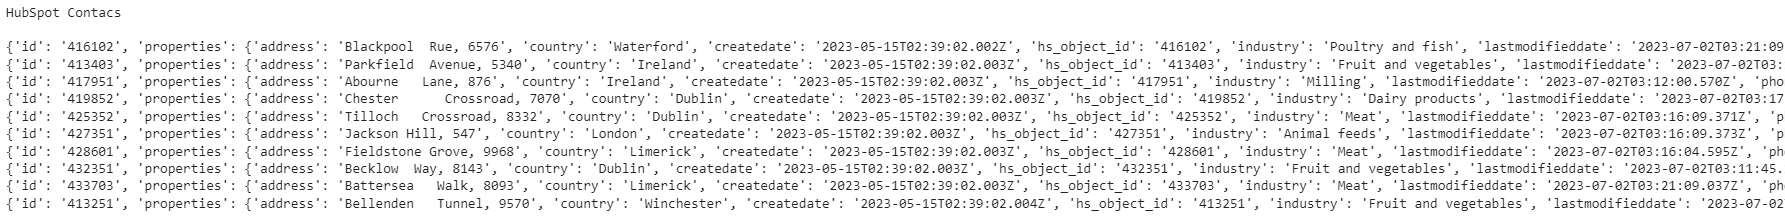


2. Segundo se crea un DataFrame con los datos o propiedades de los contactos que vamos a estar uzando para la transformacion y la carga de datos

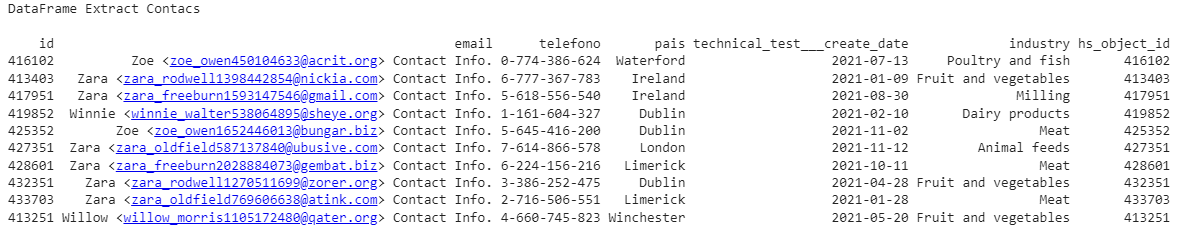

3. Tercero se realiza la transfomacion de los datos de cada contacto que se solicito en el ejercicio, se crea un DataFrame con esta informacion y se imprime

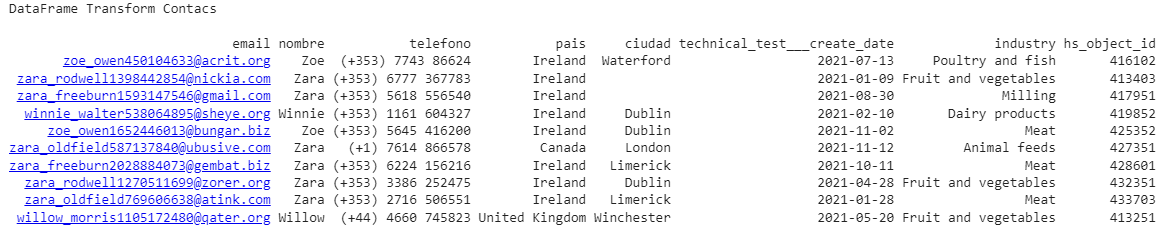

4. Cuarto se aplica la funcion de duplicate_management(transform_contacts) sobre la lista de diccionarios de los contactos con sus datos trnasfomados y se crea un DataFrame y se imprime

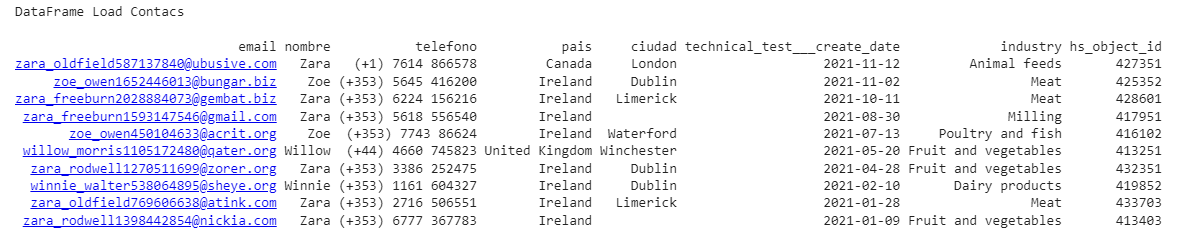

5. Quinto se realiza la carga de los datos de la lista de diccionarios load_contacts que ya estan transformados y filtrados, la carga se hace por medio de la funcion saving_contacts(load_contacts,my_access_token) a mi API privada en HubSpot, y luego imprimo si los contactos se guardaron exitosamente

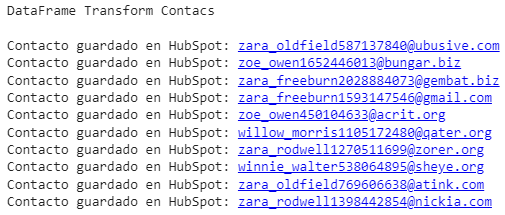

6. Se muestra los contactos guardados en HubSpot

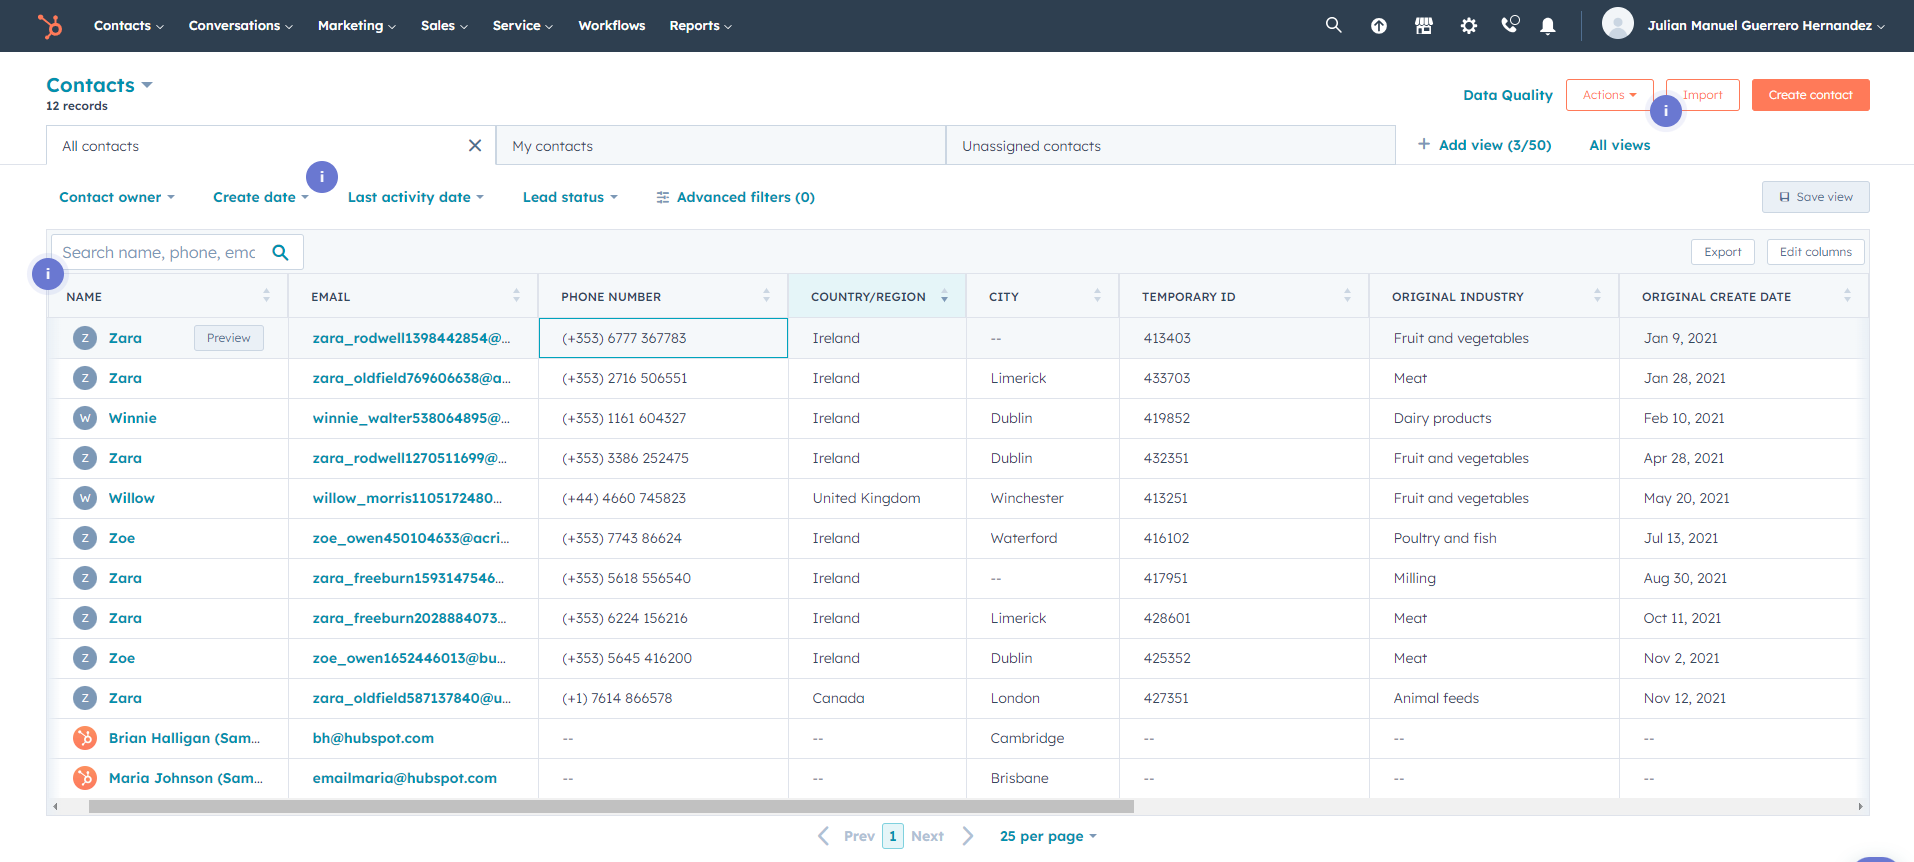

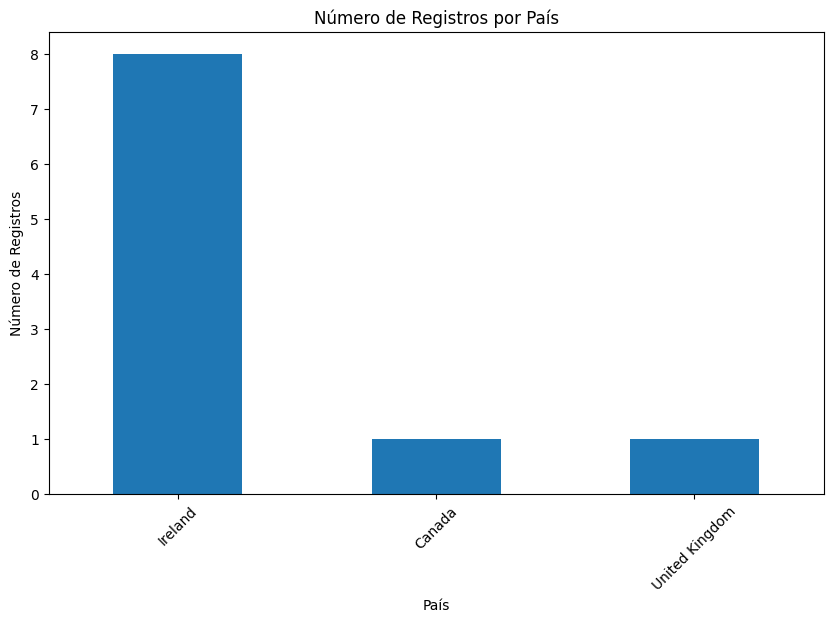

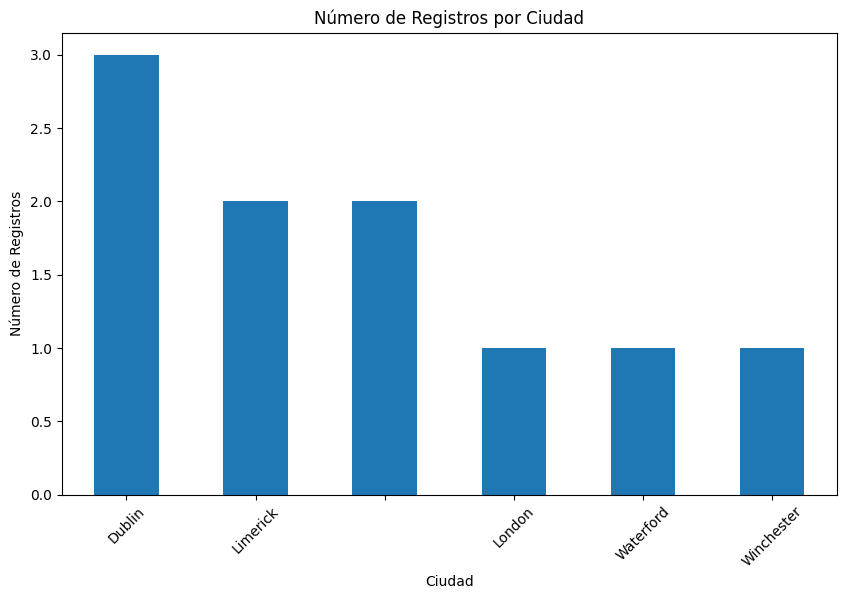

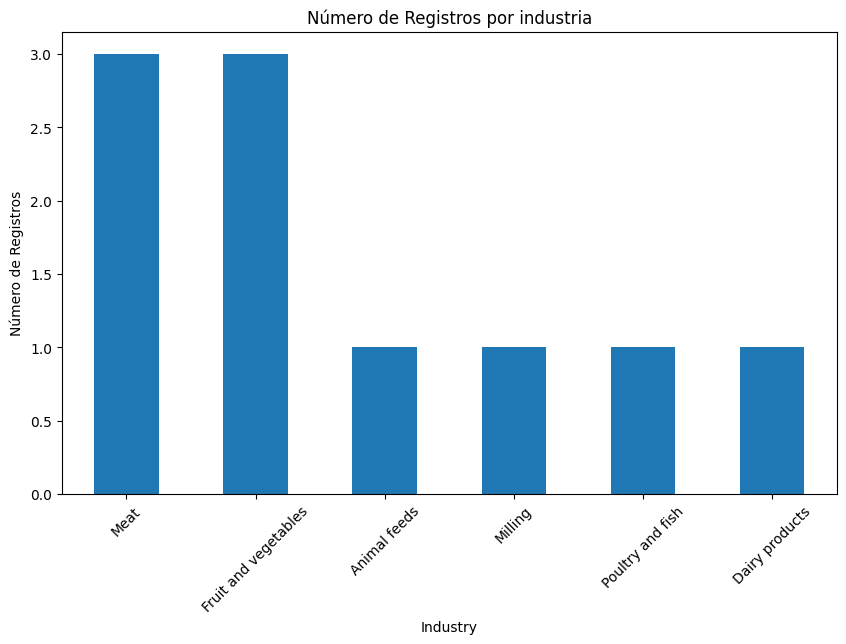

In [32]:
# %% 2. interactive graphic(s)

# Obtener el número de registros por país
df = pd.DataFrame(load_contacts)
country_counts = df['pais'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
country_counts.plot(kind='bar')
plt.title('Número de Registros por País')
plt.xlabel('País')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.show()

# Obtener el número de registros por Ciudad
city_counts = df['ciudad'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
city_counts.plot(kind='bar')
plt.title('Número de Registros por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.show()

# Obtener el número de registros por industry
industry_counts = df['industry'].value_counts()

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
industry_counts.plot(kind='bar')
plt.title('Número de Registros por industria')
plt.xlabel('Industry')
plt.ylabel('Número de Registros')
plt.xticks(rotation=45)
plt.show()

# 2. interactive graphic(s)

Se usan las librerias import matplotlib.pyplot y pandas para generar las graficas en este caso de

1. Numero de Registros X Pais
2. Numero de Registros X Ciudad
3. Numero de Registros X Industry